# Home Credit 2024

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv
/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_deposit_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_applprev_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_cb_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_3.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_tax_registry_b_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_2.parquet
/kaggle/input/home-credit-credit-risk-model-st

# Import all required dependencies

In [38]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import joblib
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

# Load Data

Depth values:

* depth=0 - These are static features directly tied to a specific *case_id*.
* depth=1 - Each *case_id* has an associated historical record, indexed by *num_group1*.
* depth=2 - Each *case_id* has an associated historical record, indexed by both *num_group1* and *num_group2*.

## Configure input paths


In [4]:
class CFG:
    root_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/")
    train_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train")
    test_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test")

## Load feature definitions

In [5]:
feature_definitions_df = pd.read_csv(CFG.root_dir / "feature_definitions.csv")
display(feature_definitions_df)
pd.reset_option("display.max_rows", 0)

,Variable,Description
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...
1,actualdpdtolerance_344P,DPD of client with tolerance.
2,addres_district_368M,District of the person's address.
3,addres_role_871L,Role of person's address.
4,addres_zip_823M,Zip code of the address.
5,amount_1115A,Credit amount of the active contract provided ...
6,amount_416A,Deposit amount.
7,amount_4527230A,Tax deductions amount tracked by the governmen...
8,amount_4917619A,Tax deductions amount tracked by the governmen...
9,amtdebitincoming_4809443A,Incoming debit card transactions amount.


## Data Collection and Preprocessing using Pipeline

In [6]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

## Aggregate data from different datasets

In [7]:
class Aggregator:
    num_aggregators = [pl.max, pl.min, pl.first, pl.last, pl.mean]
    str_aggregators = [pl.max, pl.min, pl.first, pl.last] # n_unique
    group_aggregators = [pl.max, pl.min, pl.first, pl.last]
    
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_all = []
        for method in Aggregator.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]
            expr_all += expr

        return expr_all

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]
        expr_all = []
        for method in Aggregator.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_all = []
        for method in Aggregator.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr
            
        expr_mode = [
            pl.col(col)
            .drop_nulls()
            .mode()
            .first()
            .alias(f"mode_{col}")
            for col in cols
        ]

        return expr_all + expr_mode

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_all = []
        for method in Aggregator.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_all = []
        for method in Aggregator.group_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr
            
#         if len(cols) > 0:
#             method = pl.count
#             expr = [method(col).alias(f"{method.__name__}_{col}") for col in [cols[0]]]
#             expr_all += expr

        return expr_all

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

## Read files with previous function application

In [8]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_table_dtypes))
        
    df = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

## Feature Engineering

In [9]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [10]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data

In [11]:
def reduce_mem_usage(df, float16_as32=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)                    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Prepare Dataframe

In [12]:
def prepare_df(data_dir, cat_cols=None, mode="train", display_store=False, train_cols=[]):
    print("Collecting data...")
    data_store = {
        "df_base": read_file(data_dir / f"{mode}_base.parquet"),
        "depth_0": [
            read_file(data_dir / f"{mode}_static_cb_0.parquet"),
            read_files(data_dir / f"{mode}_static_0_*.parquet"),
        ],
        "depth_1": [
            read_files(data_dir / f"{mode}_applprev_1_*.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_a_1.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_b_1.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_c_1.parquet", 1),
            read_file(data_dir / f"{mode}_credit_bureau_b_1.parquet", 1),
            read_file(data_dir / f"{mode}_other_1.parquet", 1),
            read_file(data_dir / f"{mode}_person_1.parquet", 1),
            read_file(data_dir / f"{mode}_deposit_1.parquet", 1),
            read_file(data_dir / f"{mode}_debitcard_1.parquet", 1),
        ],
        "depth_2": [
            read_file(data_dir / f"{mode}_credit_bureau_b_2.parquet", 2),
        ]
    }
    if display_store:
        display(data_store)
    
    print("Feature engeneering...")
    feats_df = feature_eng(**data_store)
    print("  feats_df shape:\t", feats_df.shape)
    
    del data_store
    gc.collect()
    
    print("Filter cols...")
    if mode == "train":
        feats_df = feats_df.pipe(Pipeline.filter_cols)
    else:
        train_cols = feats_df.columns if len(train_cols) == 0 else train_cols
        feats_df = feats_df.select([col for col in train_cols if col != "target"])
    print("  feats_df shape:\t", feats_df.shape)
    
    print("Convert to pandas...")
    feats_df = to_pandas(feats_df, cat_cols)
    return feats_df

### Configure train data

In [13]:
train_df = prepare_df(CFG.train_dir)
cat_cols = list(train_df.select_dtypes("category").columns)

Feature engeneering...
  feats_df shape:	 (1526659, 927)
Filter cols...
  feats_df shape:	 (1526659, 516)
Convert to pandas...


In [14]:
display(train_df)

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_60

In [15]:
display(cat_cols)

['description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'requesttype_4525192L',
 'bankacctype_710L',
 'cardtype_51L',
 'credtype_322L',
 'disbursementtype_67L',
 'equalitydataagreement_891L',
 'inittransactioncode_186L',
 'isdebitcard_729L',
 'lastapprcommoditycat_1041M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'lastst_736L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'twobodfilling_608L',
 'typesuite_864L',
 'max_cancelreason_3545846M',
 'max_education_1138M',
 'max_postype_4733339M',
 'max_rejectreason_755M',
 'max_rejectreasonclient_4145042M',
 'min_cancelreason_3545846M',
 'min_education_1138M',
 'min_postype_4733339M',
 'min_rejectreason_755M',
 'min_rejectreasonclient_4145042M',
 'first_cancelreason_3545846M',
 'first_education_1138M',
 'first_postype_4733339M',
 'first_rejectreason_755M',
 'first_rejectreas

### Configure test data

In [16]:
test_df = prepare_df(CFG.test_dir, cat_cols=cat_cols, mode="test", train_cols=train_df.columns)

Feature engeneering...
  feats_df shape:	 (10, 926)
Filter cols...
  feats_df shape:	 (10, 515)
Convert to pandas...


In [17]:
display(test_df)

,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,type

### Reduce memory usage and save

In [18]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 4574.60 MB
Memory usage after optimization is: 2357.21 MB
Decreased by 48.5%
Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.04 MB
Decreased by 15.4%


In [19]:
train_df.to_parquet("train_full.parquet")

# Exploration

In [20]:
print("Train is duplicated:\t", train_df["case_id"].duplicated().any())
print("Train Week Range:\t", (train_df["WEEK_NUM"].min(), train_df["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", test_df["case_id"].duplicated().any())
print("Test Week Range:\t", (test_df["WEEK_NUM"].min(), test_df["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (92, 92)


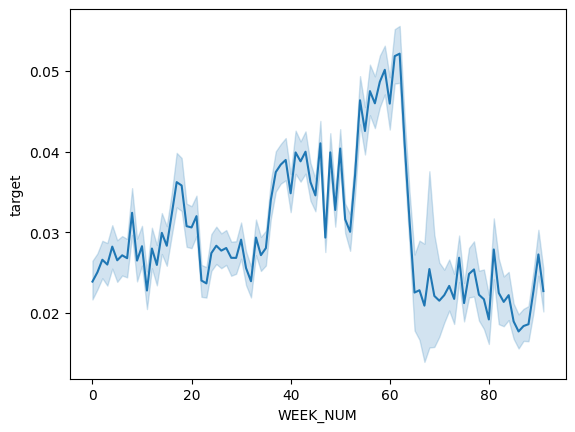

In [21]:
sns.lineplot(
        data=train_df,
        x="WEEK_NUM",
        y="target",
)
plt.show()

# Modeling

In [22]:
drop_cols = []
# drop_cols_startwith = ["std_"]
# for name_prefix in drop_cols_startwith:
#     cols_names = train_df.columns[train_df.columns.str.startswith(name_prefix)]
#     drop_cols += cols_names.to_list()
# display(drop_cols)

In [23]:
def gini_stability(base, score_col="score", w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", score_col]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", score_col]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x[score_col])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

## LGBM

In [24]:
%%time
X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"] + drop_cols)
print("X shape: ", X.shape)
y = train_df["target"]
weeks = train_df["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "max_bin": 255,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []
oof_pred = np.zeros(X.shape[0])

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )
    fitted_models.append(model)
    val_pred = model.predict_proba(X_valid)[:, 1]
    oof_pred[idx_valid] = val_pred
    gc.collect()

X shape:  (1526659, 513)


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.816476
[200]	valid_0's auc: 0.825641
[300]	valid_0's auc: 0.828455
[400]	valid_0's auc: 0.829592
[500]	valid_0's auc: 0.830186
[600]	valid_0's auc: 0.830534
[700]	valid_0's auc: 0.830829
[800]	valid_0's auc: 0.831014
[900]	valid_0's auc: 0.831346
[1000]	valid_0's auc: 0.831367
Did not meet early stopping. Best iteration is:
[909]	valid_0's auc: 0.831404
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.817025
[200]	valid_0's auc: 0.825581
[300]	valid_0's auc: 0.828764
[400]	valid_0's auc: 0.830076
[500]	valid_0's auc: 0.830432
[600]	valid_0's auc: 0.830755
[700]	valid_0's auc: 0.831091
[800]	valid_0's auc: 0.831306
[900]	valid_0's auc: 0.831397
[1000]	valid_0's auc: 0.831468
Did not meet early stopping. Best iteration is:
[981]	valid_0's auc: 0.83152
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.823026
[200]	valid_0's auc: 0.8324

In [25]:
roc_auc_oof = roc_auc_score(y, oof_pred)
print("CV roc_auc_oof: ", roc_auc_oof)

CV roc_auc_oof:  0.8348424313443554


In [26]:
oof_df = train_df[["WEEK_NUM", "target"]].copy()
oof_df["pred_oof"] = oof_pred
gini_score = gini_stability(oof_df, score_col="pred_oof")
print("gini_score:\t", gini_score)

gini_score:	 0.6492075304483129


In [27]:
oof_models_dict = [(str(i), model) for i, model in enumerate(fitted_models)]

model = VotingClassifier(
    estimators=oof_models_dict,
    voting='soft',
)
model.estimators_ = fitted_models
model.le_ = LabelEncoder().fit(y)
model.classes_ = model.le_.classes_

In [28]:
# joblib.dump(model, "oof_model_1.pkl")

['oof_model_1.pkl']

In [29]:
# joblib.dump((train_df.columns, cat_cols, drop_cols), "train_cat_columns.pkl")

['train_cat_columns.pkl']

In [30]:
# joblib.dump(oof_pred, "oof_pred.pkl")

['oof_pred.pkl']

## XGBooster (ON HOLD since require data preparation)

In [46]:
'''
%%time
# X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"] + drop_cols)
print("X shape: ", X.shape)
# y = train_df["target"]
# weeks = train_df["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "booster": "gbtee", # dart 
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 8,
    "max_bin": 255,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []
oof_pred = np.zeros(X.shape[0])

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)]
    )
    fitted_models.append(model)
    val_pred = model.predict_proba(X_valid)[:, 1]
    oof_pred[idx_valid] = val_pred
    gc.collect()
    
'''

'\n%%time\n# X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"] + drop_cols)\nprint("X shape: ", X.shape)\n# y = train_df["target"]\n# weeks = train_df["WEEK_NUM"]\n\ncv = StratifiedGroupKFold(n_splits=5, shuffle=False)\n\nparams = {\n    "booster": "gbtee", # dart \n    "objective": "binary:logistic",\n    "eval_metric": "auc",\n    "max_depth": 8,\n    "max_bin": 255,\n    "learning_rate": 0.05,\n    "n_estimators": 1000,\n    "verbose": -1,\n    "random_state": 42,\n    "device": "gpu",\n}\n\nfitted_models = []\noof_pred = np.zeros(X.shape[0])\n\nfor idx_train, idx_valid in cv.split(X, y, groups=weeks):\n    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]\n    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]\n\n    model = xgb.XGBClassifier(**params)\n    model.fit(\n        X_train, y_train,\n        eval_set=[(X_valid, y_valid)]\n    )\n    fitted_models.append(model)\n    val_pred = model.predict_proba(X_valid)[:, 1]\n    oof_pred[idx_valid] = val_pred\n  

# Results

In [ ]:
# TBD

# Prediction

In [31]:
def predict_proba_in_batches(model, data, batch_size=100000):
    num_samples = len(data)
    num_batches = int(np.ceil(num_samples / batch_size))
    probabilities = np.zeros((num_samples,))

    for batch_idx in range(num_batches):
        print(f"Processing batch: {batch_idx+1}/{num_batches}")
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        X_batch = data.iloc[start_idx:end_idx]
        batch_probs = model.predict_proba(X_batch)[:, 1]
        probabilities[start_idx:end_idx] = batch_probs
        gc.collect()

    return probabilities

In [32]:
X_test = test_df.drop(columns=["WEEK_NUM"] + drop_cols)
X_test = X_test.set_index("case_id")
print("X_test shape: ", X_test.shape)

y_pred = pd.Series(predict_proba_in_batches(model, X_test), index=X_test.index)
y_pred[:10]

X_test shape:  (10, 513)
Processing batch: 1/1


case_id
57543    0.146519
57549    0.107563
57551    0.076905
57552    0.059723
57569    0.043050
57630    0.050208
57631    0.084036
57632    0.049719
57633    0.074436
57634    0.064055
dtype: float64

# Submit

In [34]:
subm_df = pd.read_csv(CFG.root_dir / "sample_submission.csv")
subm_df = subm_df.set_index("case_id")

subm_df["score"] = y_pred

In [35]:
print("Check null: ", subm_df["score"].isnull().any())

subm_df.head()

Check null:  False


,score
case_id,
57543,0.146519
57549,0.107563
57551,0.076905
57552,0.059723
57569,0.043050


In [36]:
subm_df.to_csv("submission.csv")